## Tutorial to use explainability metrics to evaluate lime explanations via AIX360
- AIX360/metrics/local_metrics.py defines following explainablity metrics: faithfulness_metric and monotonicity_metric. This notebook borrows an example from original lime tutorial to show how to invoke these AIX360 methods to evaluate the quality of the lime explanations. 

In [1]:
import os, sys
sys.path.append("..\\")
sys.path.append("..\\..\\")
print(sys.path)

['/Users/vijay/opt/anaconda3/envs/aix360/lib/python36.zip', '/Users/vijay/opt/anaconda3/envs/aix360/lib/python3.6', '/Users/vijay/opt/anaconda3/envs/aix360/lib/python3.6/lib-dynload', '', '/Users/vijay/.local/lib/python3.6/site-packages', '/Users/vijay/opt/anaconda3/envs/aix360/lib/python3.6/site-packages', '/Users/vijay/PRODMAY24/AIX360', '/Users/vijay/Causality/gems', '/Users/vijay/opt/anaconda3/envs/aix360/lib/python3.6/site-packages/cdt-0.5.18-py3.6.egg', '/Users/vijay/opt/anaconda3/envs/aix360/lib/python3.6/site-packages/IPython/extensions', '/Users/vijay/.ipython', '..\\', '..\\..\\']


### LIME Tabular example
- Example from https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20continuous%20and%20categorical%20features.ipynb

In [2]:
from __future__ import print_function
from IPython.display import Markdown, display
from matplotlib import pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
import lime
np.random.seed(1)


from lime.lime_tabular import LimeTabularExplainer
from aix360.metrics import faithfulness_metric, monotonicity_metric

In [3]:
iris = sklearn.datasets.load_iris()

In [4]:
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(iris.data, 
                                                                                  iris.target, 
                                                                                  train_size=0.80)

In [5]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train, labels_train)

RandomForestClassifier(n_estimators=500)

In [6]:
sklearn.metrics.accuracy_score(labels_test, rf.predict(test))

0.9666666666666667

In [7]:
explainer = LimeTabularExplainer(train, 
                             feature_names=iris.feature_names, 
                             class_names=iris.target_names, 
                             discretize_continuous=True)

In [8]:
print(type(explainer))

<class 'lime.lime_tabular.LimeTabularExplainer'>


In [9]:
i = np.random.randint(0, test.shape[0])
exp = explainer.explain_instance(test[i], rf.predict_proba, num_features=4, top_labels=1)

In [10]:
exp.as_map()

{0: [(3, 0.4551816923537021),
  (2, 0.4266276817864536),
  (0, 0.03833847261345117),
  (1, 0.01858900999520372)]}

### Using AIX360 Explainability metrics to evaluate quality of explanations ###

Get the local explanation and find the weights assigned to the features. Create a array of base (don't care) values for comparison. For iris dataset, we assume a base value of 0 for each atribute.

In [11]:
predicted_class = rf.predict(test[i].reshape(1,-1))[0]
le = exp.local_exp[predicted_class]

m = exp.as_map()

x = test[i]
coefs = np.zeros(x.shape[0])

for v in le:
    coefs[v[0]] = v[1]


base = np.zeros(x.shape[0])


print("Faithfulness: ", faithfulness_metric(rf, x, coefs, base))
print("Monotonity: ", monotonicity_metric(rf, x, coefs, base))

Faithfulness:  -0.6039274026768449
Monotonity:  True


while the Faithfulness metric deems the explanation to be weak, it is considered to be ok using the Monotonicity metric.

Lets explore further by evaluating these metrics on the entire test set.

In [12]:
ncases = test.shape[0]
mon = np.zeros(ncases)
for i in range(ncases):
    predicted_class = rf.predict(test[i].reshape(1,-1))[0]
    exp = explainer.explain_instance(test[i], rf.predict_proba, num_features=4, top_labels=1)
    le = exp.local_exp[predicted_class]
    m = exp.as_map()
    
    x = test[i]
    coefs = np.zeros(x.shape[0])
    
    for v in le:
        coefs[v[0]] = v[1]

    mon[i] = monotonicity_metric(rf, test[i], coefs, base)
print("% of test records where explanation is monotonic",np.mean(mon))

% of test records where explanation is monotonic 0.8333333333333334


More than 80% of the explanations are monotonic. Hence, the LIME explanations are fairly good using this measure.

In [13]:
fait = np.zeros(ncases)
for i in range(ncases):
    predicted_class = rf.predict(test[i].reshape(1,-1))[0]
    exp = explainer.explain_instance(test[i], rf.predict_proba, num_features=4, top_labels=1)
    le = exp.local_exp[predicted_class]
    m = exp.as_map()
    
    x = test[i]
    coefs = np.zeros(x.shape[0])
    
    for v in le:
        coefs[v[0]] = v[1]
    fait[i] = faithfulness_metric(rf, test[i], coefs, base)

print("Faithfulness metric mean: ",np.mean(fait))
print("Faithfulness metric std. dev.:", np.std(fait))

 

Faithfulness metric mean:  0.4746905765290242
Faithfulness metric std. dev.: 0.6278959319743475


The value of the faithfulness metric can be between -1.0 and 1.0. So, a mean value of around 0.5 shows that the LIME explanations are fairly good via this metric.
Moreover, the high std. deviation shows that the distribution has probably a large number of cases with high correlation. So, we look at a histogram of faithfulness metric values for all the cases.

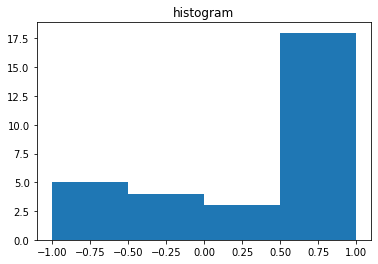

In [14]:
plt.hist(fait, bins = [-1.0,-0.5,0,0.5,1.0]) 
plt.title("histogram") 
plt.show()

This shows that most the explanations produced by LIME are 'faithful'. Only a few of the explanations are not good using this metric